## 1. Setup & Environment Configuration

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import lightgbm as lgb
import optuna




# System and utilities
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 2. Data Loading & Initial Exploration

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# Display basic information
print("\n📋 Dataset Overview:")
df.head()



📋 Dataset Overview:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print("\n🔢 Data Types:")
print(df.dtypes)
print("\n📈 Basic Statistics:")
df.describe()


🔢 Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

📈 Basic Statistics:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 3. Data Cleaning & Preprocessing <a name="data-cleaning"></a>

In [5]:
def check_missing_values(df):
    """Check and print missing values summary."""
    total_missing = df.isnull().sum().sum()
    cols_missing = df.columns[df.isnull().any()].tolist()

    print("🔍 Missing Values Analysis:")
    print("=" * 40)
    print(f"Total missing values: {total_missing}")
    print(f"Columns with missing values: {cols_missing}")

    if cols_missing:
        print("\\n📊 Missing values by column:")
        missing_by_col = df.isnull().sum()
        for col in cols_missing:
            pct = (missing_by_col[col] / len(df)) * 100
            print(f"  {col}: {missing_by_col[col]} ({pct:.1f}%)")

    return cols_missing

def impute_missing_values(df, cols_with_missing):
    """Impute missing values based on user groups."""

    print("\\n🔧 Imputing Missing Values:")
    print("=" * 40)

    # Numerical columns: impute with user's median
    numerical_cols = ['Transaction_Amount', 'Time_of_Transaction']
    for col in numerical_cols:
        if col in cols_with_missing:
            original_missing = df[col].isnull().sum()
            df[col] = df.groupby('User_ID')[col].transform(
                lambda x: x.fillna(x.median()) if not x.empty else x
            )
            remaining_missing = df[col].isnull().sum()
            print(f"✅ {col}: {original_missing - remaining_missing} imputed, {remaining_missing} remaining")

    # Categorical columns: impute with user's mode
    categorical_cols = ['Device_Used', 'Location', 'Payment_Method']
    for col in categorical_cols:
        if col in cols_with_missing:
            original_missing = df[col].isnull().sum()
            df[col] = df.groupby('User_ID')[col].transform(
                lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
            )
            remaining_missing = df[col].isnull().sum()
            print(f"✅ {col}: {original_missing - remaining_missing} imputed, {remaining_missing} remaining")

    return df

# Check for missing values
cols_with_missing = check_missing_values(df)

# Impute missing values if any exist
if cols_with_missing:
    df = impute_missing_values(df, cols_with_missing)

    # Drop users with only one transaction and still missing values
    users_with_one_tx = df.groupby('User_ID').filter(
        lambda x: (len(x) == 1) & (x.isnull().any().any())
    )

    if len(users_with_one_tx) > 0:
        print(f"\\n🗑️ Dropping {len(users_with_one_tx)} users with single transactions and missing values")
        df = df.drop(users_with_one_tx.index)

# Final check
final_missing = df.isnull().sum().sum()
print(f"\n✅ Data cleaning complete! Final missing values: {final_missing}")
print(f"📊 Final dataset shape: {df.shape}")

🔍 Missing Values Analysis:
Total missing values: 0
Columns with missing values: []

✅ Data cleaning complete! Final missing values: 0
📊 Final dataset shape: (7043, 21)


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
def preprocess_data(df: pd.DataFrame, target_col: str = "Churn") -> pd.DataFrame:
    """
    We need to.
    - trim column names
    - drop obvious ID cols
    - fix TotalCharges to numeric
    - map target Churn to 0/1 if needed
    - simple NA handling
    """

    df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace

    # drop ids if present
    for col in ["customerID", "CustomerID", "customer_id"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # target to 0/1 if it's Yes/No
    if target_col in df.columns and df[target_col].dtype == "object":
        df[target_col] = df[target_col].str.strip().map({"No": 0, "Yes": 1})

    # TotalCharges often has blanks in this dataset -> coerce to float
    if "TotalCharges" in df.columns:
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

    # SeniorCitizen should be 0/1 ints if present
    if "SeniorCitizen" in df.columns:
        df["SeniorCitizen"] = df["SeniorCitizen"].fillna(0).astype(int)

    # simple NA strategy:
    # - numeric: fill with 0
    # - others: leave for encoders to handle (get_dummies ignores NaN safely)
    num_cols = df.select_dtypes(include=["number"]).columns
    df[num_cols] = df[num_cols].fillna(0)

    return df

In [8]:
# make src importable
sys.path.append(os.path.abspath('..') )
from src.data.build_features import build_features

RAW = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
OUT = "../data/Telco-Customer-Churn_processed.csv"


# preprocess (drops id, fixes TotalCharges, etc.)
df = preprocess_data(df, target_col="Churn")

# ensure target is 0/1 only if still object
if "Churn" in df.columns and df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].str.strip().map({"No": 0, "Yes": 1}).astype("Int64")

# sanity checks
assert df["Churn"].isna().sum() == 0, "Churn has NaNs after preprocess"
assert set(df["Churn"].unique()) <= {0, 1}, "Churn not 0/1 after preprocess"

# features
df_processed = build_features(df, target_col="Churn")

# 5) save
os.makedirs(os.path.dirname(OUT), exist_ok=True)
df_processed.to_csv(OUT, index=False)
print(f"✅ Processed dataset saved to {OUT} | Shape: {df_processed.shape}")

🔧 Starting feature engineering on 20 columns...
   📊 Found 15 categorical and 5 numeric columns
   🔢 Binary features: 5 | Multi-category features: 10
      Binary: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
      Multi-category: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
      ✅ gender: object → binary (0/1)
      ✅ Partner: object → binary (0/1)
      ✅ Dependents: object → binary (0/1)
      ✅ PhoneService: object → binary (0/1)
      ✅ PaperlessBilling: object → binary (0/1)
   🌟 Applying one-hot encoding to 10 multi-category columns...
      ✅ Created 21 new features from 10 categorical columns
✅ Feature engineering complete: 31 final features
✅ Processed dataset saved to ../data/Telco-Customer-Churn_processed.csv | Shape: (7043, 31)


In [9]:
df1 = pd.read_csv('../data/Telco-Customer-Churn_processed.csv')
df1.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True


## 4. Exploratory Data Analysis <a name="eda"></a>

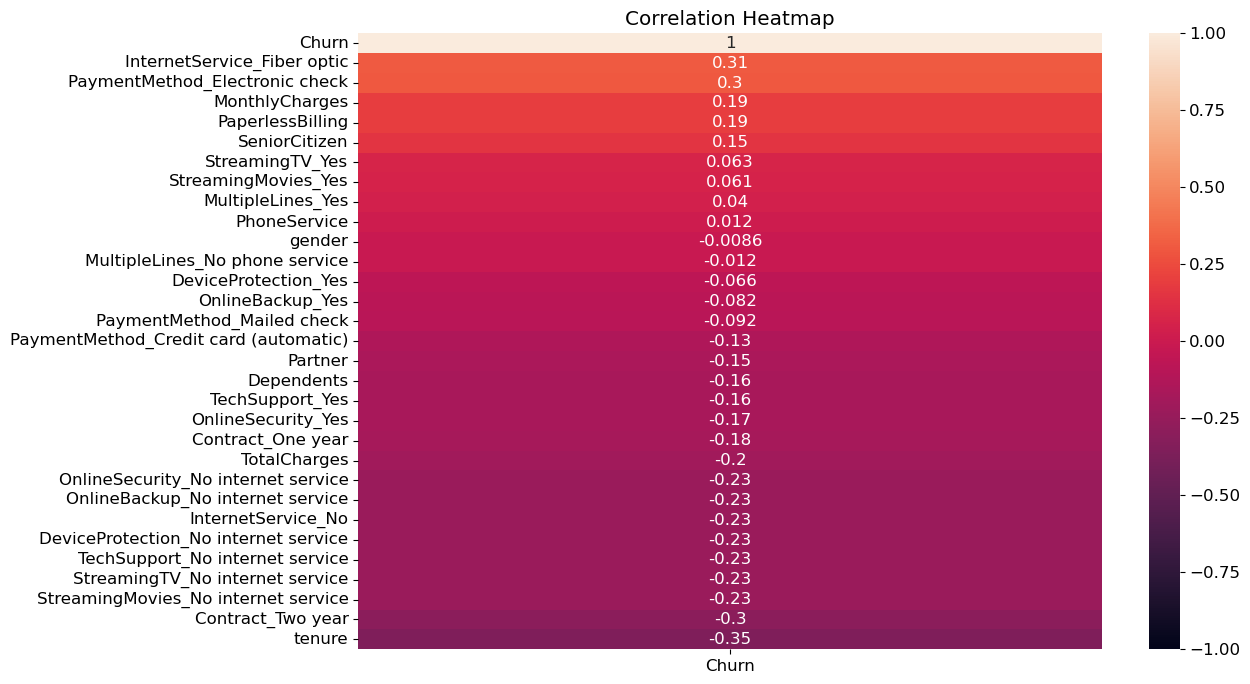

In [12]:
corr = df1.corr(numeric_only=True)
churn_corr = corr[['Churn']].sort_values(by='Churn', ascending=False)

sns.heatmap(churn_corr, annot=True, vmax=1, vmin=-1)
plt.title("Correlation Heatmap")
plt.show()

## 5. ML

In [17]:
def plot_and_print_distribution(df, column_name):
    """
    Plots the distribution of a categorical column and prints the percentage of each category.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the categorical column to analyze.
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return

    # Calculate the counts and percentages
    counts = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True) * 100

    # Print the percentages
    print(f"\n{column_name} Distribution (%):")
    for value, percentage in percentages.items():
        print(f"{value}: {percentage:.2f}%")

    # Create a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.index, y=counts.values, palette='viridis')

    # Adding titles and labels
    plt.title(f'{column_name} Distribution', fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(axis='y')

    # Show the plot
    plt.show()


Churn Distribution (%):
0: 73.46%
1: 26.54%


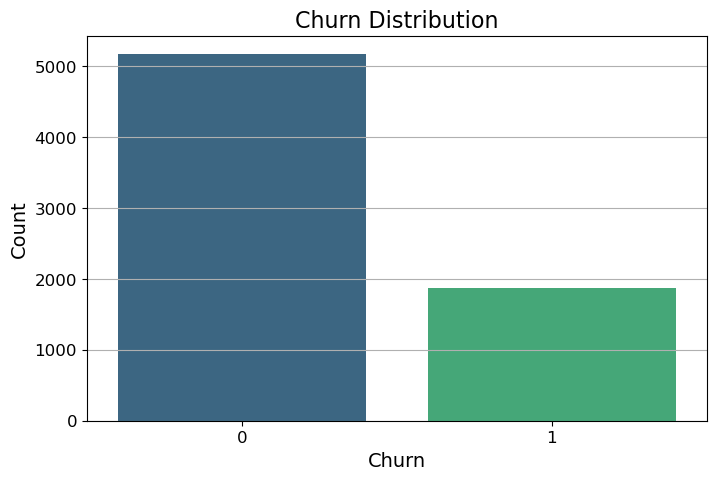

In [19]:
# Before any kind of training let check if this dataset suffer from the classic imbalance problem
plot_and_print_distribution(df1, 'Churn')

In [21]:
X = df1.drop(columns=["Churn"])
y = df1["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
THRESHOLD = 0.3



In [23]:
# Random Forest
randF = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

randF.fit(X_train, y_train)
prob = randF.predict_proba(X_test)[:, 1]
y_pred = (prob > THRESHOLD).astype(int)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.882     0.768     0.821      1035
           1      0.528     0.717     0.608       374

    accuracy                          0.754      1409
   macro avg      0.705     0.742     0.714      1409
weighted avg      0.788     0.754     0.765      1409



In [27]:
# LGBM
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Training timer
start_train = time.time()
lgbm.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱ Training time: {train_time:.2f} seconds")

# Prediction timer
start_pred = time.time()
proba = lgbm.predict_proba(X_test)[:, 1]
y_pred = (proba >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f"⏱ Prediction time: {pred_time:.4f} seconds")

# Classification report
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
⏱ Training time: 0.96 seconds
⏱ Prediction time: 0.0082 seconds
              precision    recall  f1-score   support

           0      0.914     0.695     0.789      1035
           1      0.492     0.818     0.614       374

    accuracy                          0.727      1409
   macro avg      0.703     0.756     0.702      1409
weighted avg      0.802     0.72

In [31]:
# XGBOOST
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

# Training timer
start_train = time.time()
xgb.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱ Training time: {train_time:.2f} seconds")

# Prediction timer
start_pred = time.time()
prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (prob >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f"⏱ Prediction time: {pred_time:.4f} seconds")

# Classification report
print(classification_report(y_test, y_pred, digits=3))

⏱ Training time: 2.42 seconds
⏱ Prediction time: 0.0056 seconds
              precision    recall  f1-score   support

           0      0.915     0.694     0.789      1035
           1      0.492     0.821     0.615       374

    accuracy                          0.727      1409
   macro avg      0.703     0.757     0.702      1409
weighted avg      0.802     0.727     0.743      1409



In [32]:
prob = xgb.predict_proba(X_test)[:, 1]

print("Threshold tuning for XGBoost")

print(f"{'Thresh':<8}{'Prec_1':<8}{'Rec_1':<8}{'F1_1':<8}")
for thresh in [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
    preds = (proba >= thresh).astype(int)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)
    print(f"{thresh:<8}{prec:<8.3f}{rec:<8.3f}{f1:<8.3f}")

Threshold tuning for XGBoost
Thresh  Prec_1  Rec_1   F1_1    
0.25    0.468   0.845   0.602   
0.3     0.492   0.821   0.615   
0.35    0.502   0.781   0.611   
0.4     0.517   0.754   0.614   
0.45    0.534   0.735   0.619   
0.5     0.542   0.701   0.611   


### Finetuning

In [34]:
# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= THRESHOLD).astype(int)  # Keep your tuned threshold
    return recall_score(y_test, y_pred, pos_label=1)  # Optimize recall for churners

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Params:", study.best_params)
print("Best Recall:", study.best_value)

[I 2025-09-20 03:27:53,691] A new study created in memory with name: no-name-c3009b38-efd4-4e23-a257-e723b8545223
[I 2025-09-20 03:27:54,699] Trial 0 finished with value: 0.8850267379679144 and parameters: {'n_estimators': 775, 'learning_rate': 0.10867558986309135, 'max_depth': 9, 'subsample': 0.8026777152677533, 'colsample_bytree': 0.6656373540489172, 'min_child_weight': 5, 'gamma': 3.042884997298679, 'reg_alpha': 1.5544055446649918, 'reg_lambda': 1.6724621171274012}. Best is trial 0 with value: 0.8850267379679144.
[I 2025-09-20 03:27:55,502] Trial 1 finished with value: 0.9037433155080213 and parameters: {'n_estimators': 799, 'learning_rate': 0.08414013242812132, 'max_depth': 7, 'subsample': 0.8558239285149809, 'colsample_bytree': 0.7009201257184996, 'min_child_weight': 4, 'gamma': 4.964860647363044, 'reg_alpha': 1.398525022877013, 'reg_lambda': 4.45441872875375}. Best is trial 1 with value: 0.9037433155080213.
[I 2025-09-20 03:27:55,809] Trial 2 finished with value: 0.90641711229946

Best Params: {'n_estimators': 508, 'learning_rate': 0.02988553719639235, 'max_depth': 10, 'subsample': 0.9253132735906686, 'colsample_bytree': 0.7560065761735583, 'min_child_weight': 3, 'gamma': 4.9766258773661205, 'reg_alpha': 4.964757159479986, 'reg_lambda': 3.940059895012239}
Best Recall: 0.9117647058823529


In [35]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Add the scale_pos_weight and fixed params to the best ones from Optuna
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "n_jobs": -1,
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": "logloss"
})

# Create model from best params
xgb = XGBClassifier(**best_params)

# Training timer
start_train = time.time()
xgb.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱ Training time: {train_time:.2f} seconds")

# Prediction timer
start_pred = time.time()
proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (proba >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f"⏱ Prediction time: {pred_time:.4f} seconds")

# Classification report
print(classification_report(y_test, y_pred, digits=3))

⏱ Training time: 0.22 seconds
⏱ Prediction time: 0.0053 seconds
              precision    recall  f1-score   support

           0      0.947     0.575     0.716      1035
           1      0.437     0.912     0.590       374

    accuracy                          0.664      1409
   macro avg      0.692     0.743     0.653      1409
weighted avg      0.812     0.664     0.682      1409



In [36]:
import mlflow
import mlflow.sklearn  # or mlflow.xgboost
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score
import time
import os

# Force MLflow to always use the project root's mlruns folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
mlflow.set_tracking_uri(f"file://{project_root}/mlruns")
mlflow.set_experiment("Telco Churn - XGBoost")

with mlflow.start_run():
    # Calculate scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Best params from Optuna
    best_params = study.best_params
    best_params.update({
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": scale_pos_weight,
        "eval_metric": "logloss"
    })

    # Log parameters
    mlflow.log_params(best_params)

    # Training timer
    start_train = time.time()
    xgb = XGBClassifier(**best_params)
    xgb.fit(X_train, y_train)
    train_time = time.time() - start_train
    mlflow.log_metric("train_time", train_time)

    # Prediction
    start_pred = time.time()
    proba = xgb.predict_proba(X_test)[:, 1]
    y_pred = (proba >= THRESHOLD).astype(int)
    pred_time = time.time() - start_pred
    mlflow.log_metric("pred_time", pred_time)

    # Metrics
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, proba)

    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("roc_auc", auc)

    # Save model
    mlflow.xgboost.log_model(xgb, "model")

    print(classification_report(y_test, y_pred, digits=3))

2025/09/20 03:33:46 INFO mlflow.tracking.fluent: Experiment with name 'Telco Churn - XGBoost' does not exist. Creating a new experiment.
2025/09/20 03:33:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/20 03:33:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


              precision    recall  f1-score   support

           0      0.947     0.575     0.716      1035
           1      0.437     0.912     0.590       374

    accuracy                          0.664      1409
   macro avg      0.692     0.743     0.653      1409
weighted avg      0.812     0.664     0.682      1409

